In [1]:
!pip install emoji contractions wordcloud

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.1/345.1 kB 26.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 113.9/113.9 kB 8.8 MB/s eta 0:00:00


# **IMPORT LIBRARY**

In [2]:
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sentence_transformers import SentenceTransformer
from nltk.tokenize import word_tokenize
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from nltk.corpus import stopwords
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import contractions
import numpy as np
import hdbscan
import joblib
import string
import emoji
import umap
import nltk
import re

# **DOENLOAD NLTK RESOURCE**

In [3]:
nltk.download('punkt')
nltk.download('omw-1.4')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

# **LOAD DATASET**

In [4]:
df = pd.read_csv('/content/drive/MyDrive/NLP/scraping-tradingview-review.csv')
df = df[['content']].dropna()

In [5]:
df

content
0     Update: the scroll wheels on the time frames a...
1     I am aspiring forex trader currently demo trad...
2     I can honestly say that this app is really hel...
3     I've seen the workaround for it in the respons...
4     App has been updated, and now works flawlessly...
...                                                 ...
1995  RSI & MACD are very basic things ...Why it is ...
1996  My chart colour settings keep going back to de...
1997  I see error on my chart section (an error occu...
1998  I can't use app because when I go to app and c...
1999  Great app, but will stop using if the new 30 s...

[2000 rows x 1 columns]

# **PREPROCESSING TEXT**

## **Function untuk preprocessing**

In [6]:
def clean_text(text):
    # Lowercase - Mengubah semua huruf menjadi huruf kecil untuk konsistensi.
    text = text.lower()

    # Expand Contractions - Mengubah bentuk kontraksi menjadi bentuk lengkap, misalnya: "I'm" → "I am" ; can't → cannot
    text = contractions.fix(text)

    # Remove URLs - Menghapus URL dari teks.
    text = re.sub(r'http\S+|www\S+', '', text)

    # Remove emojis using emoji lib - Menghapus semua emoji yang ada pada teks
    text = emoji.replace_emoji(text, replace='')

    # Remove punctuation - Menghapus semua tanda baca.
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Remove numbers - Menghapus semua angka.
    text = re.sub(r'\d+', '', text)

    # Tokenize - Memecah teks menjadi kata-kata (token) individual menggunakan word_tokenize.
    words = word_tokenize(text)

    # Remove stopwords - Menghapus kata-kata umum (seperti "the", "is", "and") yang tidak mengandung makna penting dalam analisis.
    stop_words = set(stopwords.words('english'))
    words = [w for w in words if w not in stop_words]

    # Remove specific words - Menghapus kata "app"
    custom_remove = {'app'}
    words = [w for w in words if w not in custom_remove]

    return ' '.join(words)

## **Menerapkan preprocessing pada dataset**

In [7]:
# menerapkan preproses ke dataset
df['clean_content'] = df['content'].apply(clean_text)

# menampilkan 10 sampel data hasil preproses
print(df[['content', 'clean_content']].head(10))

# simpan hasil preproses
df.to_csv('cleaned_reviews.csv', index=False)

                                             content  \
0  Update: the scroll wheels on the time frames a...   
1  I am aspiring forex trader currently demo trad...   
2  I can honestly say that this app is really hel...   
3  I've seen the workaround for it in the respons...   
4  App has been updated, and now works flawlessly...   
5  Update - the latest response is what I was loo...   
6  Now lists have a terrible pop up, you can't ju...   
7  Super super good! The cellphone touch interfac...   
8  Really digging it so far. Still has a number o...   
9  The mobile app needs some optimization to acco...   

                                       clean_content  
0  update scroll wheels time frames ticker great ...  
1  aspiring forex trader currently demo trading u...  
2  honestly say really helpful gives alot free tr...  
3  seen workaround responses also going point bad...  
4  updated works flawlessly tab corrected issue b...  
5  update latest response looking thanks recent u... 

# **Sentence-BERT Embedding**

## **Load SBERT model**

In [8]:
model = SentenceTransformer('all-mpnet-base-v2')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

## **Generate embeddings**

In [9]:
embeddings = model.encode(df['clean_content'].tolist(), show_progress_bar=True)

Batches:   0%|          | 0/63 [00:00<?, ?it/s]

## **Save embeddings**

In [10]:
np.save('sbert_embeddings.npy', embeddings)
joblib.dump(df, 'preprocessed_reviews.pkl')

print("\n Embedding selesai")


 Embedding selesai


# **Membuat objek PCA yang akan mereduksi dimensi**

***Mengurangi kompleksitas data untuk mempercepat proses analisis atau pemodelan.***

In [11]:
pca = PCA(n_components=2, random_state=42) # berarti hasil akhir akan berada dalam 2 dimensi
reduced_embeddings = pca.fit_transform(embeddings)

# **Elbow Method to Find Optimal k**

***Elbow Method digunakan untuk menentukan jumlah cluster (k) yang optimal dalam algoritma K-Means Clustering.***

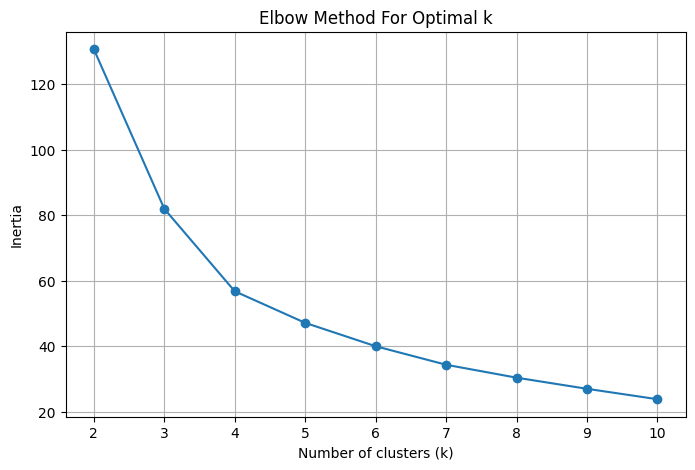

In [12]:
inertia = []
k_range = range(2, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(reduced_embeddings)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(k_range, inertia, marker='o')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.grid(True)
plt.savefig('elbow_plot.png')
plt.show()

# **KMeans Clustering (Set k manually after elbow analysis)**

## **Modelling KMeans dengan k yang sesuai**

In [13]:
optimal_k = 4
kmeans = KMeans(
    n_clusters=optimal_k,      # jumlah cluster yang optimal, dihitung sebelumnya
    init='k-means++',          # metode inisialisasi, 'k-means++' cenderung lebih stabil
    n_init=10,                 # jumlah inisialisasi berbeda yang dicoba (default mulai 2024: 'auto')
    max_iter=500,              # jumlah maksimum iterasi per inisialisasi
    tol=1e-6,                  # toleransi untuk konvergensi
    random_state=42,           # seed agar hasil bisa direproduksi
    algorithm='elkan'          # algoritma ('lloyd', 'elkan', atau 'auto')
)

labels = kmeans.fit_predict(reduced_embeddings)
df['kmeans_cluster'] = labels

## **Evaluasi - KMeans**

In [14]:
sil_score = silhouette_score(reduced_embeddings, labels)
db_score = davies_bouldin_score(reduced_embeddings, labels)

print(f"\n✅ KMeans selesai (k={optimal_k})")
print(f"Silhouette Score: {sil_score:.3f}")
print(f"Davies-Bouldin Score: {db_score:.3f}")


✅ KMeans selesai (k=4)
Silhouette Score: 0.423
Davies-Bouldin Score: 0.797


## **Simpan hasil akhir**

In [15]:
joblib.dump(df, 'clustered_reviews.pkl')
df.to_csv('clustered_reviews.csv', index=False)

## **Visualisasi Klaster - KMeans**

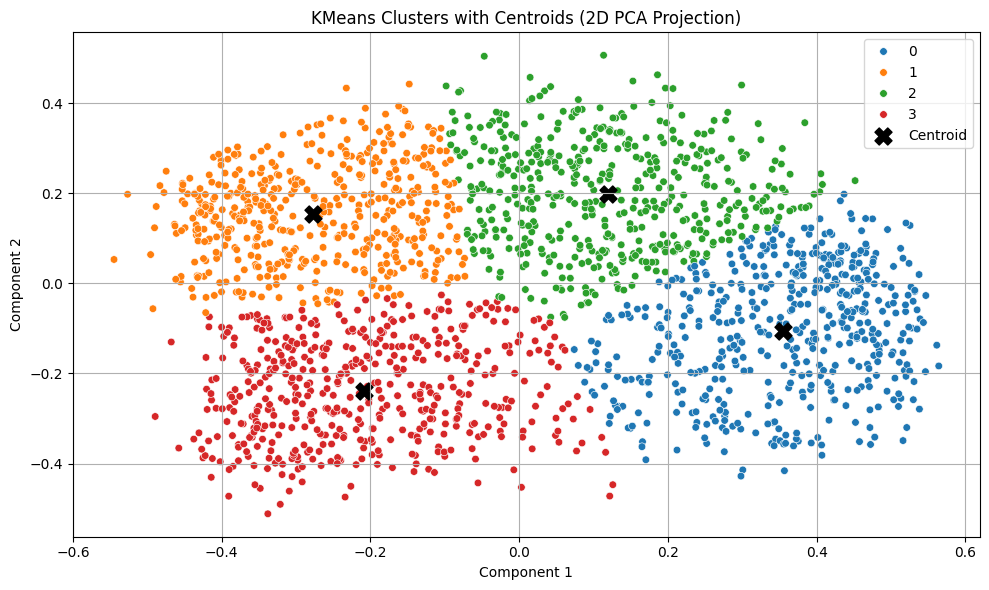

In [16]:
# Ambil centroid langsung dari model
centroids = kmeans.cluster_centers_

# Buat DataFrame untuk visualisasi
df_plot = pd.DataFrame({
    'x': reduced_embeddings[:, 0],
    'y': reduced_embeddings[:, 1],
    'cluster': labels
})

# Plot hasil klaster dan centroid
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_plot, x='x', y='y', hue='cluster', palette='tab10', s=30)

# Tambahkan centroid
plt.scatter(centroids[:, 0], centroids[:, 1],
            c='black', marker='X', s=150, label='Centroid')

plt.title('KMeans Clusters with Centroids (2D PCA Projection)')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('kmeans_clusters_centroids.png')
plt.show()


## **Menampilkan sampel teks & wordcloud dari tiap kluster**



--- KMeans Cluster 0 ---
Contoh Ulasan:
1. aspiring forex trader currently demo trading useful mefrom ui functionality available tools everything well put togetheri able analyze charts mobile phone virtually precision would laptopnow impressive big props developersas someone else revieweda lot work put shows lot
2. honestly say really helpful gives alot free trading signals indicators want indicators turned though start paying month free access still gives alot worth using pay though get use apply technical indicators copy professional analytics clean ui easy navigate supports dark mode well also accurate lagging market pulse
3. best charting platform available difficult create drawings using phone due smaller screen large fingers imagine would work really well tablet andor stylus think well done issues syncs seamlessly tradingview accounts via cloud great interface nearly features available desktop browser version highly recommend
4. fantastic charting functionality truly top notch 

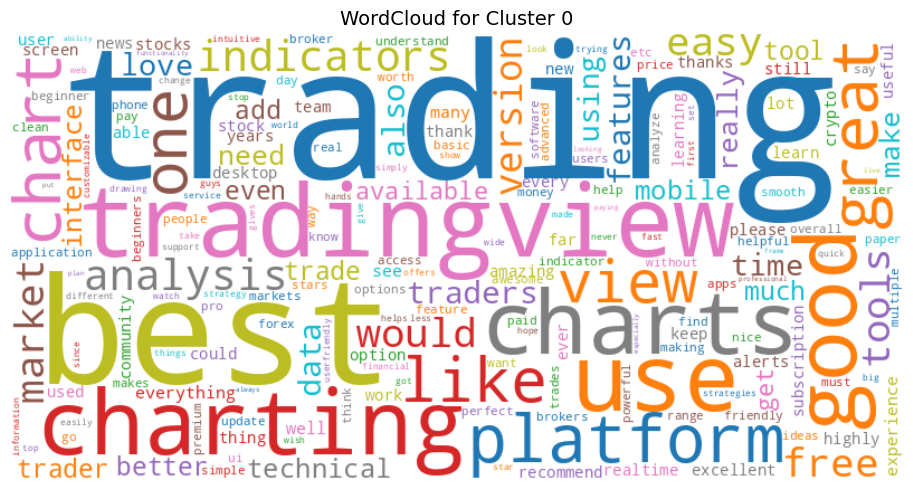



--- KMeans Cluster 1 ---
Contoh Ulasan:
1. updated works flawlessly tab corrected issue back stars looking stock chart everything fine tap stock ticker name top left corner choose different ticker look screen rotates portrait even though tablet landscape super wonky seems unfinished rate higher due gets fixed change rating thanks samsung galaxy tab
2. really digging far still number visual glitches screen zooms either impossibly impossibly close also scrollingzooming viewport indicators move sync sometimes turn indicators fix usually considering scripts built community expected started basic payed version see goes
3. edit fixed update thank favorite time frames point favorite time frames easy access kind dumb design favorite time frames used top easy access one click click bottom change iphone able scroll bottom switch favorite tf makes sense android ui horrible renew premium year awful design
4. desktop version fantastic however leave screen open idle seconds freezes hard reset phon

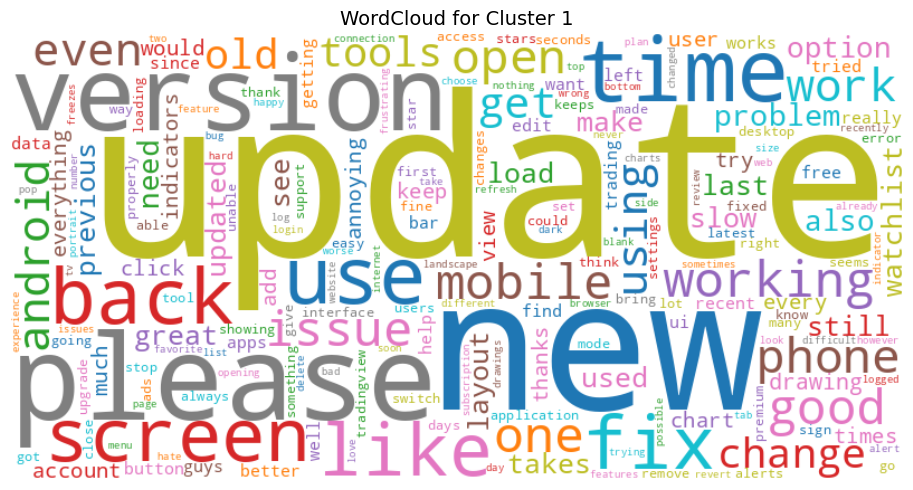



--- KMeans Cluster 2 ---
Contoh Ulasan:
1. super super good cellphone touch interface brilliant tons data course indicators easy add charts zooming zooming extremely intuitive fast data easy see cellphone get better trading getting subscription update bought black friday special set alerts alert woke bought bitcoin alert woke back sold less hours made money back
2. mobile needs optimization account reduced screen size service excellent well worth money tablet course easier use increased screen real estate could use tutorial features gestures navigate example idea find alerts thing
3. love options tradingview complaint ea option without connecting mt pinescript really problem however learning curve learn platforms well become proficient tradingview well yet still good platform lots options
4. love used almost everyday last years honestly say major issues feature many name top notched editable customisable slight learning curve easy use get lot relates markets put time effort learn som

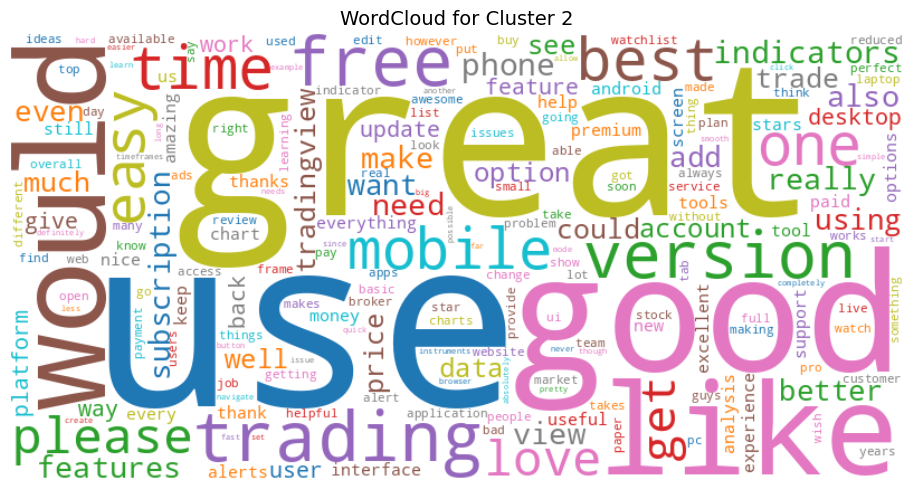



--- KMeans Cluster 3 ---
Contoh Ulasan:
1. update scroll wheels time frames ticker great update new ui older ui efficient please bring back option retain time single tap changed require single tap ui failure point changing things sake aesthetics
2. seen workaround responses also going point bad ux new popup click symbol get full chart latest update pointless please default back going straight chart click symbol otherwise course love tradingview still think unparalleled
3. update latest response looking thanks recent update click watchlist symbol one month line chart opens click maximize far right get saved layout candles indicators change really annoying response quick overview yahoo finance one uses charting tool stick good please change make setting choice
4. lists terrible pop click chart see getba pop available chart settings makes feel chunky fluid magnet drawing lines hard fingers way needs way use tools move without fingers way tap hold crosshairs used move around without need

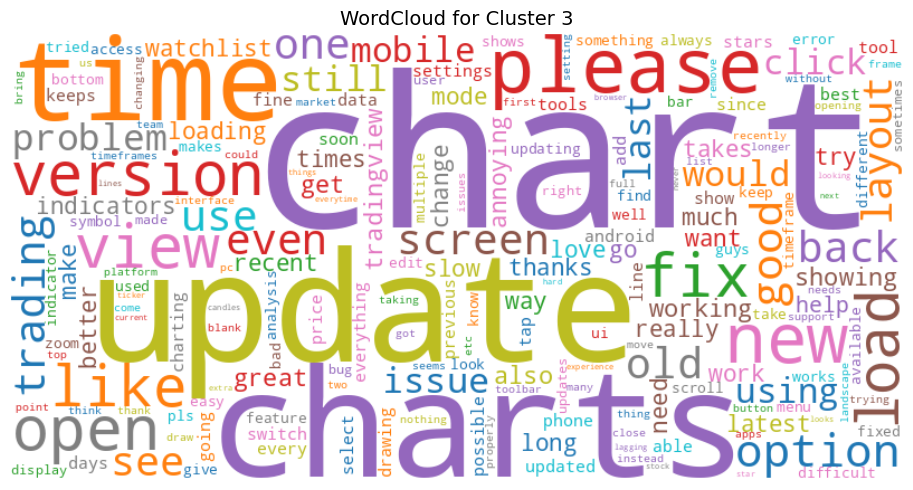

In [33]:
from wordcloud import WordCloud
from collections import Counter
import matplotlib.pyplot as plt

for cluster_id in sorted(df['kmeans_cluster'].unique()):
    if cluster_id == -1:
        continue  # abaikan outlier jika ada

    print(f"\n\n--- KMeans Cluster {cluster_id} ---")

    # Ambil contoh ulasan
    sample_texts = df[df['kmeans_cluster'] == cluster_id]['clean_content'].head(5)
    print("Contoh Ulasan:")
    for i, text in enumerate(sample_texts, 1):
        print(f"{i}. {text}")

    # Gabungkan semua teks dalam klaster
    all_texts = ' '.join(df[df['kmeans_cluster'] == cluster_id]['clean_content'].tolist())

    # Hitung frekuensi kata (tanpa menghapus stopwords tambahan)
    words = all_texts.split()
    frequencies = Counter(words)

    # Tampilkan 10 kata paling sering
    print("Top 10 kata:", frequencies.most_common(10))

    # Buat dan tampilkan WordCloud
    wordcloud = WordCloud(
        width=800, height=400,
        background_color='white',
        colormap='tab10'
    ).generate_from_frequencies(frequencies)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'WordCloud for Cluster {cluster_id}', fontsize=14)
    plt.tight_layout()
    plt.show()


In [18]:
# Save final clustered dataset
df.to_csv('clustered_reviews.csv', index=False)
joblib.dump(df, 'clustered_reviews.pkl')

['clustered_reviews.pkl']

# **HDBSCAN Clustering**

## **Modelling HDBSCAN**

In [19]:
hdb = hdbscan.HDBSCAN(
    min_cluster_size=63,
    metric='euclidean',
    cluster_selection_method='eom'
)
hdb_labels = hdb.fit_predict(reduced_embeddings)
df['hdbscan_cluster'] = hdb_labels

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


## **Evaluasi - HDBSCAN**

In [20]:
# Evaluasi HDBSCAN (exclude -1/outliers)
valid_indices = df['hdbscan_cluster'] != -1
if valid_indices.sum() > 1:
    sil_h = silhouette_score(reduced_embeddings[valid_indices], df.loc[valid_indices, 'hdbscan_cluster'])
    db_h = davies_bouldin_score(reduced_embeddings[valid_indices], df.loc[valid_indices, 'hdbscan_cluster'])
    print(f"\n✅ HDBSCAN selesai")
    print(f"Silhouette Score: {sil_h:.3f}")
    print(f"Davies-Bouldin Score: {db_h:.3f}")
else:
    print("\n⚠️ Tidak cukup klaster valid untuk evaluasi HDBSCAN.")


✅ HDBSCAN selesai
Silhouette Score: 0.625
Davies-Bouldin Score: 0.444


## **Visualisasi Kluster - HDBSCAN**

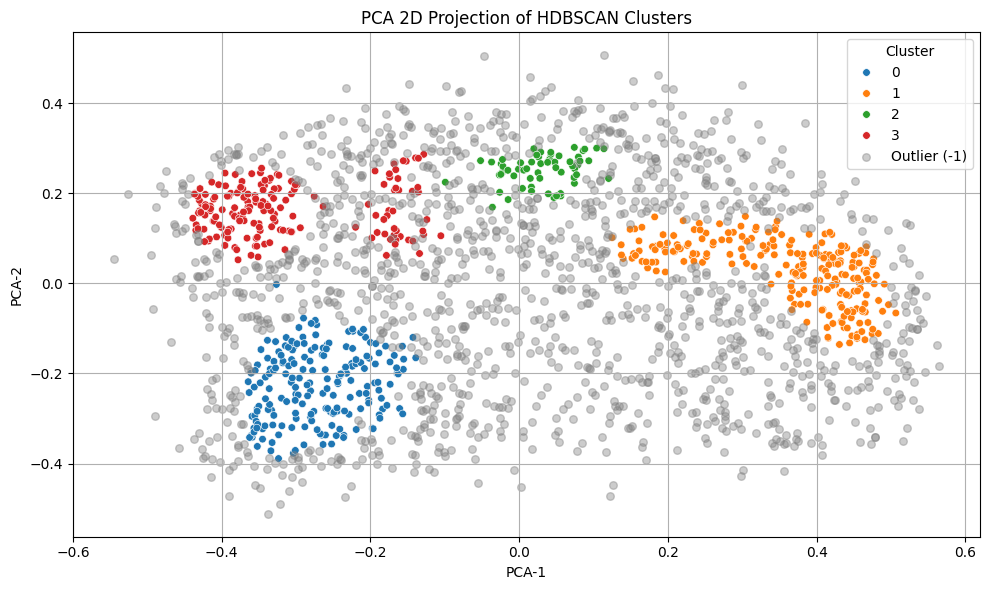

In [25]:
# Tambahkan ke df
df['pca_x'] = reduced_embeddings[:, 0]
df['pca_y'] = reduced_embeddings[:, 1]

# memisahkan data outlier dan non-outlier
df_outliers = df[df['hdbscan_cluster'] == -1].copy()
df_clusters = df[df['hdbscan_cluster'] != -1].copy()

plt.figure(figsize=(10, 6))

# plot klaster non-outlier dengan warna default (palette tab10)
sns.scatterplot(
    data=df_clusters,
    x='pca_x', y='pca_y',
    hue='hdbscan_cluster',
    palette='tab10',
    s=30,
)

# plot outlier secara terpisah (abu-abu, transparan)
plt.scatter(
    df_outliers['pca_x'],
    df_outliers['pca_y'],
    color='gray',
    alpha=0.4,
    s=30,
    label='Outlier (-1)'
)

plt.title('PCA 2D Projection of HDBSCAN Clusters')
plt.xlabel('PCA-1')
plt.ylabel('PCA-2')
plt.legend(title='Cluster')
plt.grid(True)
plt.tight_layout()
plt.savefig('pca_2d_hdbscan_with_outliers_gray.png')
plt.show()


## **Menampilkan sampel teks dan wordcloud tiap kluster**



--- KMeans Cluster 0 ---
Contoh Ulasan:
1. great access charts functional form going mobile browser really needs manual refresh button though recent update makes click multiple times get real chart instead first click goes line chat good tv come simple lines update tv responded quickly told fix back
2. one point wanted delete drawn lines chart message displayed asking wanted delete locked shapes well good option unfortunately mistakenly selected option ask question deletes locked unlocked drawings together reset option unlocked shapes deleted chart
3. love trading view however last daysweeks noticed widget throwing error notification every time try update recent prices oops something wrong great great platform
4. able seamlessly creat ratio charts example gldslv functionality seems completely gone mobile happened please fix elaborate broke update edit problem fixed thanks love
5. going back switching another charts automatically refresh come latest time stay point left annoying go ba

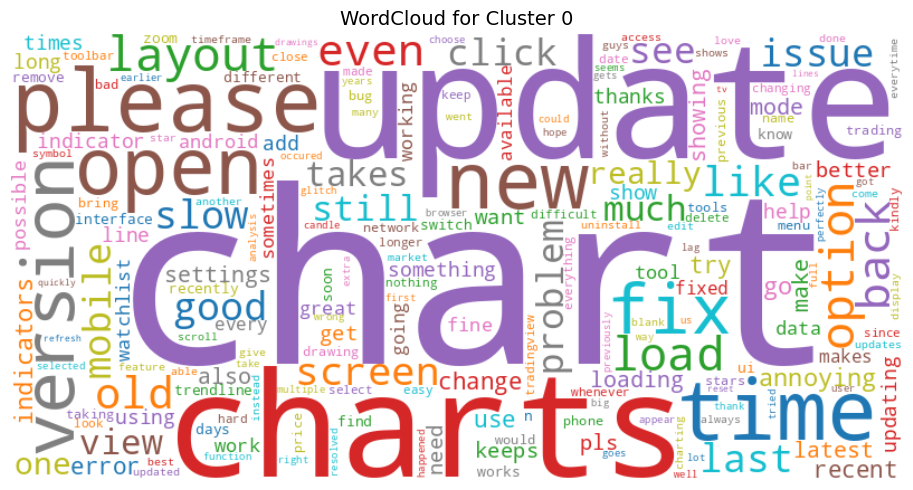



--- KMeans Cluster 1 ---
Contoh Ulasan:
1. aspiring forex trader currently demo trading useful mefrom ui functionality available tools everything well put togetheri able analyze charts mobile phone virtually precision would laptopnow impressive big props developersas someone else revieweda lot work put shows lot
2. honestly say really helpful gives alot free trading signals indicators want indicators turned though start paying month free access still gives alot worth using pay though get use apply technical indicators copy professional analytics clean ui easy navigate supports dark mode well also accurate lagging market pulse
3. use almost every day easy use clear unambiguous charting builtin indicators community designed scripting interface creating configurable alerts keep top profit strategies real time data markets available top performance requires fairly date hardware everything expect top performance fossil
4. absolutely priceless application would recommend anyone piece toget

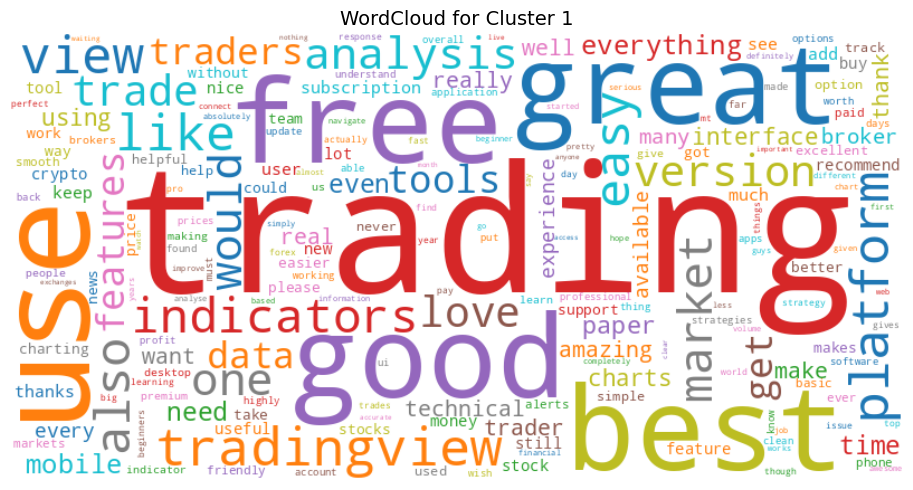



--- KMeans Cluster 2 ---
Contoh Ulasan:
1. good would like side bar easy choose favorite tools minimisable create room would recommend
2. pretty good good scripting executions real time without lag slightly clunky places think gotten better time
3. love love update need absorb fxreplay include service money people would pay doubt
4. great easy use suggestion please make easy add pinescript mobile struggling pinescript
5. awesome almost good desktop version love info palm hand
Top 10 kata: [('like', 15), ('time', 14), ('good', 13), ('great', 12), ('use', 10), ('make', 9), ('would', 8), ('love', 8), ('version', 8), ('alert', 8)]


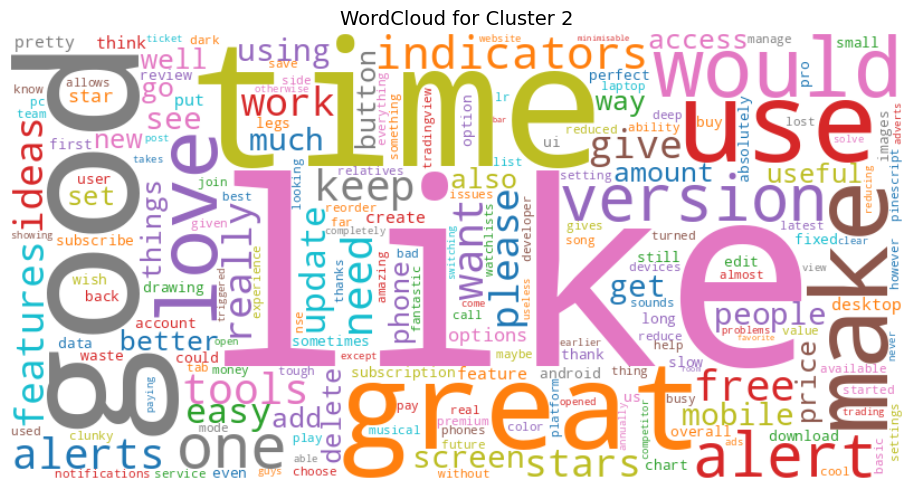



--- KMeans Cluster 3 ---
Contoh Ulasan:
1. really digging far still number visual glitches screen zooms either impossibly impossibly close also scrollingzooming viewport indicators move sync sometimes turn indicators fix usually considering scripts built community expected started basic payed version see goes
2. edit fixed update thank favorite time frames point favorite time frames easy access kind dumb design favorite time frames used top easy access one click click bottom change iphone able scroll bottom switch favorite tf makes sense android ui horrible renew premium year awful design
3. one thing would really like see ability set favorites bar vertical horizontal otherwise great
4. sofar good pls consider add zoom pinescript small edit script without glasses
5. panel v historic alerts sended account thanks assistance found
Top 10 kata: [('update', 64), ('new', 41), ('please', 38), ('version', 32), ('time', 31), ('screen', 29), ('back', 28), ('working', 26), ('open', 24), ('fix',

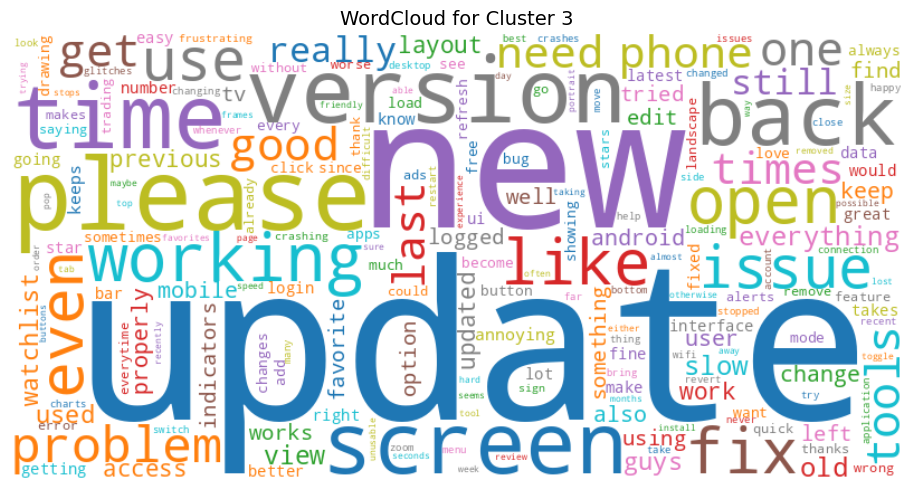

In [35]:
for cluster_id in sorted(df['hdbscan_cluster'].unique()):
    if cluster_id == -1:
        continue  # abaikan outlier jika ada

    print(f"\n\n--- KMeans Cluster {cluster_id} ---")

    # Ambil contoh ulasan
    sample_texts = df[df['hdbscan_cluster'] == cluster_id]['clean_content'].head(5)
    print("Contoh Ulasan:")
    for i, text in enumerate(sample_texts, 1):
        print(f"{i}. {text}")

    # Gabungkan semua teks dalam klaster
    all_texts = ' '.join(df[df['hdbscan_cluster'] == cluster_id]['clean_content'].tolist())

    # Hitung frekuensi kata (tanpa menghapus stopwords tambahan)
    words = all_texts.split()
    frequencies = Counter(words)

    # Tampilkan 10 kata paling sering
    print("Top 10 kata:", frequencies.most_common(10))

    # Buat dan tampilkan WordCloud
    wordcloud = WordCloud(
        width=800, height=400,
        background_color='white',
        colormap='tab10'
    ).generate_from_frequencies(frequencies)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'WordCloud for Cluster {cluster_id}', fontsize=14)
    plt.tight_layout()
    plt.show()


## **simpan hasil beserta klusternya**

In [36]:
df.to_csv('clustered_reviews.csv', index=False)
joblib.dump(df, 'clustered_reviews_hdbscan_improved.pkl')

['clustered_reviews_hdbscan_improved.pkl']